# Bispectrum function test notebook
Test python implementation of bispectrum function fun_compute_bispectrum.m by Kevin Martins.

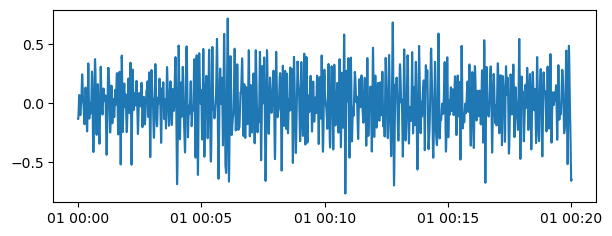

In [17]:
# Imports
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import detrend, windows
import matplotlib.pyplot as plt
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import transfer_functions as rptf

# Load test data from RBR SoloD pressure sensor
data_root = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
datadir = os.path.join(data_root, 'RBRDuetDT', 'Level1', 'netcdf')
fn = os.path.join(datadir, 'Asilomar_2022_SSA_L1_RBRDuetDT_210358_pressure.nc')
dsp = xr.decode_cf(xr.open_dataset(fn, decode_coords='all'))

# Sampling frequency
fs = 16

# Read/take out test sample (hydrostatic surface)
outdir = '/home/mikapm/Github/Martins_pressure_reconstruction/data'
fn_test = os.path.join(outdir, 'test_data.csv')
if not os.path.isfile(fn_test):
    dt = 0.0625
    t0 = pd.Timestamp('2022-07-01 00:00:00.000000')
    t1 = pd.Timestamp('2022-07-01 00:20:00.000000') - pd.Timedelta(seconds=dt)
    dsp = dsp.sel(time=slice(t0, t1))
    # Make regularly spaced time index
    time_reg = pd.date_range(t0, t1, freq='62500U')
    # Remove possible duplicate samples
    dsp = dsp.sel(time=~dsp.get_index("time").duplicated())
    # Reindex dataset to regular time index
    dsp = dsp.reindex(time=time_reg, method='nearest')
    # Compute (and detrend) hydrostatic surface
    h0 = dsp.z_hyd.mean().item() # Mean water depth
    eta_hyd = detrend(dsp.z_hyd - h0)

    # Save test data in csv format
    dfe = pd.DataFrame(data={'eta_hyd':eta_hyd, 'z_hyd':dsp.z_hyd.values}, 
                       index=time_reg)
    dfe.index = dfe.index.rename('time')
    dfe.to_csv(fn_test)
else:
    dfe = pd.read_csv(fn_test, parse_dates=['time']).set_index('time')
    h0 = dfe['z_hyd'].mean().item()
    eta_hyd = dfe['eta_hyd'].values.squeeze()

# Quick check by plotting eta_hyd
fig, ax = plt.subplots(figsize=(7,2.5))
ax.plot(dfe.index, eta_hyd)
plt.show()

In [104]:
# Compute spectrum and estimate peak frequency
dss = rpws.spec_uvz(eta_hyd, fs=16)

# Compute shallowness and nonlinearity parameters
fp = 1 / dss.Tp_Y95.item() # Peak frequency following Young (1995)
kp = rptf.waveno_full(2*np.pi*fp, d=h0).item()
mu = (kp * h0)**2
mu_info = 'Shallowness parameter'
eps = 2 * np.nanstd(eta_hyd)
eps_info = 'Nonlinear "amplitude" parameter'
Ur = eps / mu
Ur_info  = 'Ursell parameter'
print('h0={:.4f}, kp={:.4f}, mu={:.4f}, eps={:.4f}, Ur={:.4f}'.format(h0, kp, mu, eps, Ur))

# Nonlinear moderately dispersive reconstruction 
nfft = 512 * fs
overlap  = 75
mg_bis   = 5
x = eta_hyd.copy()
lx = len(x)
wind = 'rect'

# Bispectrum calculation
overlap = min(99, max(overlap, 0))
nfft -= np.remainder(nfft, 2)
eadvance = int(np.fix(nfft * overlap / 100))
nadvance = int(nfft - eadvance)
nblock   = int(np.fix((lx - eadvance) / nadvance)) # +1 for not throwing any data out
print('overlap={}, nfft={}, eadvance={}, nadvance={}, nblock={}'.format(
    overlap, nfft, eadvance, nadvance, nblock))

freqs = np.arange(-nfft/2, nfft/2+1) / nfft * fs
df = freqs[1] - freqs[0]

# Initialize arrays
P = np.zeros(nfft+1) # Power spectrum [m^2]
B = np.zeros((nfft+1, nfft+1)) # Bispectrum [m^3]
print('freqs={}, len(freqs)={}, df={}, P={}, B={}'.format(freqs, len(freqs), df, 
    P.shape, B.shape))

# Initialization
A = np.zeros((nfft, nblock)).astype(complex) # Fourier coeffs for each block
nmid = int(nfft / 2) # Middle frequency index (f = 0)
locseg = np.arange(nfft) # Indices for first block

# Computing FFT (loop over blocks)
for kk in range(nblock):
    # print('kk: ', kk)
    # Preparing block kk timeseries
    # For the rectangular window, we force a certain continuity between blocks
    xseg = x[locseg]
    xseg = detrend(xseg) # Detrend
    xseg -= np.mean(xseg) # De-mean
    if wind == 'rect':
        # Trying to make it periodic
        count = 0
        while abs(xseg[-1]-xseg[0]) > 0.2*np.std(xseg):
            # Updating locseg
            if kk == 0:
                locseg += 1
            else:
                locseg -= 1
            # Updating xseg
            xseg = x[locseg]
            count += 1
        if count > 1:
            xseg = detrend(xseg) # Detrend
            xseg -= np.mean(xseg) # De-mean
        # Smoothing both the timeseries' head and tail
        beg_ts = xseg[:2*fs] 
        end_ts = xseg[-2*fs:]
        merged_ts0 = np.concatenate([end_ts, beg_ts])
        merged_ts = merged_ts0.copy()
        dti = int(np.round(fs/8))
        for tt in range(dti, len(merged_ts)-dti-1):
            merged_ts[tt] = np.mean(merged_ts0[tt-dti:tt+dti+1])
            # print('m: ', merged_ts0[tt-dti:tt+dti+1])
        xseg[:2*fs] = merged_ts[-2*fs:]
        xseg[-2*fs:] = merged_ts[:2*fs]
        
        # Final windowing
        ww = windows.boxcar(nfft) 
        normFactor = np.mean(ww**2)
        xseg *= (ww / np.sqrt(normFactor))

        # FFT of segment
        A_loc = np.fft.fft(xseg , nfft) / nfft
        A[:,kk] = np.concatenate([A_loc[nmid:nfft], A_loc[:nmid]]) # FFTshift
        A[nmid,kk] = 0

        # Indices for next block
        locseg += nadvance



h0=6.0434, kp=0.1067, mu=0.4160, eps=0.4551, Ur=1.0941
overlap=75, nfft=8192, eadvance=6144, nadvance=2048, nblock=6
freqs=[-8.         -7.99804688 -7.99609375 ...  7.99609375  7.99804688
  8.        ], len(freqs)=8193, df=0.001953125, P=(8193,), B=(8193, 8193)
xseg:  [-0.01937851 -0.02241207 -0.02237687 -0.01479193 -0.00744439 -0.00045739
  0.00626561  0.01241592  0.01818176  0.02371942]
xseg:  [-0.08151076 -0.09699625 -0.12511271 -0.16100531 -0.19778876 -0.23399505
 -0.26938506 -0.30295076 -0.33480845 -0.36429281]
xseg:  [0.29406026 0.29366471 0.29923239 0.29438236 0.28911459 0.2825698
 0.27509441 0.26716393 0.25841441 0.24859225]
xseg:  [0.36517077 0.37477979 0.38724587 0.39994345 0.41092369 0.4201399
 0.42741602 0.43313246 0.43781306 0.44156432]
xseg:  [0.20927164 0.23018952 0.23877381 0.24011424 0.2397271  0.23716926
 0.23324079 0.22704467 0.21909382 0.20953326]
xseg:  [-0.17655605 -0.15797618 -0.13539798 -0.11655696 -0.09677238 -0.07635644
 -0.05482145 -0.0325628  -0.00964728  0.

In [96]:
A[:,kk].shape

(8193,)